In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from itertools import compress, combinations
%matplotlib inline

In [2]:
n = 50

In [3]:
def function(x):
    '''
    Array-friendly 4-step function on [0,1.]
    '''
    return 10*np.sum([x >= k/5 for k in [1,2,3,4]], axis=0)

In [4]:
def k_rbf(x,z,gamma):
    '''
    rbf (gaussian kernel)
    '''
    return np.exp(-gamma*np.square(x-z))

In [5]:
x_data = np.array([(i-1)/(n-1) for i in range(1,n+1)])
np.random.seed(1)
y_data = np.array([0 if i==25 else 1 for i in range(1,n+1)])*(function(x_data) + np.random.randn(n))

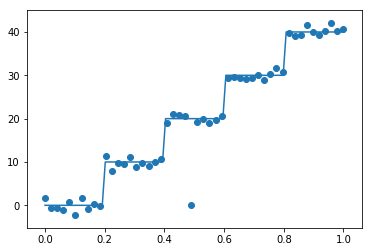

In [6]:
x = np.linspace(0,1,100)
plt.plot(x, function(x))
plt.scatter(x_data, y_data)

"DCP errors [discplined convex programming errors] can occur if K is non-symmetric (solved by doing (K+K')/2) or has negative eigenvalues (but very very very small negative just due to numerical precision). You can either compute the eigenvalue decomposition of K and explciitly set the negative eigenvalues to 0, or add a bit of identity matrix." Another solution is to use functions that may have these kinds of protections built in (like quadratic forms).

In [7]:
def ls_loss_fn(residuals, params=None):
    return cp.pnorm(residuals, p=2)**2

def huber_loss_fn(residuals, params):
    M = params
    return np.sum([i for i in cp.huber(residuals, M)])

def regularizer(alpha, K):
    return cp.quad_form(alpha, K)

In [8]:
def cvx_kernel_1d(x, y, loss_fn, loss_params, kernel, k_params, lambd):
    '''
    Return function that computes sum over all alpha-weighted kernel data vectors 
    for each new x (each x_p in possible many x_predict).
    
    Notes on cvxpy:
    (1) The optimal objective value is returned by `cp.Problem.solve()`.
    (2) After solve, optimal value for alpha is stored in `alpha.value`.
    
    @requires loss_fn take args ([K,alpha,y],*loss_params)
    Expect that x_predict is an iterable of x_p data
    '''
    xi, xj = np.meshgrid(x, x)
    K = kernel(xi, xj, k_params)
    
    alpha = cp.Variable(len(x))
    _lambd = cp.Parameter(nonneg=True)
    _lambd.value = lambd
    
    residuals = cp.matmul(K, alpha) - y
    objective = cp.Minimize(loss_fn(residuals, loss_params) + _lambd*regularizer(alpha, K))
    prob = cp.Problem(objective)
    prob.solve()
    
    return lambda x_predict: np.array([np.sum(alpha.value*kernel(x, x_p, k_params))
                                       for x_p in x_predict])

In [231]:
def cvx_kernel_1d_type2(x, y, loss_fn, loss_params, kernel, k_params, lambd1, lambd2):
    xi, xj = np.meshgrid(x, x)
    K = kernel(xi, xj, k_params)
    
    n = len(x)
    alpha = cp.Variable(n)
    D = -1*np.identity(n)[:-1] + np.identity(n)[1:]
    _lambd1 = cp.Parameter(nonneg=True)
    _lambd2 = cp.Parameter(nonneg=True)
    _lambd1.value = lambd1
    _lambd2.value = lambd2
    
    residuals = cp.matmul(K, alpha) - y
    objective = cp.Minimize(loss_fn(residuals, loss_params) 
                            + _lambd1 * cp.norm1(cp.matmul(D, cp.matmul(K, alpha)))
                            + _lambd2 * regularizer(alpha, K))
    prob = cp.Problem(objective)
    prob.solve()
    
    return lambda x_predict: np.array([np.sum(alpha.value*kernel(x, x_p, k_params))
                                       for x_p in x_predict])

In [247]:
def cvx_kernel_1d_type3(x, y, loss_fn, loss_params, kernel, k_params, lambd):
    xi, xj = np.meshgrid(x, x)
    K = kernel(xi, xj, k_params)
    
    n = len(x)
    D = -1*np.identity(n)[:-1] + np.identity(n)[1:]
    alpha = cp.Variable(n)
    _lambd = cp.Parameter(nonneg=True)
    _lambd.value = lambd
    
    residuals = cp.matmul(K, alpha) - y
    objective = cp.Minimize(loss_fn(residuals, loss_params) + _lambd*regularizer(alpha, K))
    constraints = [cp.matmul(D, cp.matmul(K, alpha)) >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return lambda x_predict: np.array([np.sum(alpha.value*kernel(x, x_p, k_params))
                                       for x_p in x_predict])

In [9]:
def k_fold_cv(k, x, y, loss_fn, loss_params, kernel, k_params, lambd):
    '''
    Returns the average loss of the k-fold cross validation.
    @requires len(x)/k in integers (creates len(x)/k folds)
    '''
    n = len(x)
    indices = np.arange(n).astype(int)
    k_folds = np.random.permutation(indices).reshape(int(n/k), k) # Each row is a k-fold. 
    k_loss = np.zeros(int(n/k))
    for i, k_validation in enumerate(k_folds):
        select_train = np.ones(n).astype(int)
        select_train[k_validation] = 0
        x_train = np.array([xi for xi in compress(x, select_train)])
        y_train = np.array([yi for yi in compress(y, select_train)])
        
        f_hat_k = cvx_kernel_1d(x_train, y_train, loss_fn, loss_params, kernel, k_params, lambd)
        
        residuals = y[k_validation]-f_hat_k(x[k_validation])
        k_loss[i] = (loss_fn(residuals, loss_params)/len(k_validation)).value
    return np.mean(k_loss)

In [229]:
def k_fold_cv_type2(k, x, y, loss_fn, loss_params, kernel, k_params, lambd1, lambd2):
    '''
    Returns the average loss of the k-fold cross validation.
    @requires len(x)/k in integers (creates len(x)/k folds)
    '''
    n = len(x)
    indices = np.arange(n).astype(int)
    k_folds = np.random.permutation(indices).reshape(int(n/k), k) # Each row is a k-fold. 
    k_loss = np.zeros(int(n/k))
    for i, k_validation in enumerate(k_folds):
        select_train = np.ones(n).astype(int)
        select_train[k_validation] = 0
        x_train = np.array([xi for xi in compress(x, select_train)])
        y_train = np.array([yi for yi in compress(y, select_train)])
        
        f_hat_k = cvx_kernel_1d_type2(x_train, y_train, loss_fn, loss_params, kernel, k_params, lambd1, lambd2)
        
        residuals = y[k_validation]-f_hat_k(x[k_validation])
        k_loss[i] = (loss_fn(residuals, loss_params)/len(k_validation)).value
    return np.mean(k_loss)

In [238]:
def k_fold_cv_type3(k, x, y, loss_fn, loss_params, kernel, k_params, lambd):
    n = len(x)
    indices = np.arange(n).astype(int)
    k_folds = np.random.permutation(indices).reshape(int(n/k), k) # Each row is a k-fold. 
    k_loss = np.zeros(int(n/k))
    for i, k_validation in enumerate(k_folds):
        select_train = np.ones(n).astype(int)
        select_train[k_validation] = 0
        x_train = np.array([xi for xi in compress(x, select_train)])
        y_train = np.array([yi for yi in compress(y, select_train)])
        
        f_hat_k = cvx_kernel_1d_type3(x_train, y_train, loss_fn, loss_params, kernel, k_params, lambd)
        
        residuals = y[k_validation]-f_hat_k(x[k_validation])
        k_loss[i] = (loss_fn(residuals, loss_params)/len(k_validation)).value
    return np.mean(k_loss)

In [137]:
gamma_h = 1/np.median([(i[0]-i[1])**2 for i in combinations(x_data,2)]) # Use the heuristic
print(gamma_h)

10.671111111111111


## Part (a)

In [12]:
g_max = 1000
g_min = 1

lambd_max = 5
lambd_min = .005

best_error_ls = np.inf
best_ls = []

for i in range(100):
    gamma0 = np.random.rand()*(g_max-g_min) + g_min
    lambd0 = np.random.rand()*(lambd_max-lambd_min) + lambd_min
    error = k_fold_cv(5, x_data, y_data, ls_loss_fn, None, k_rbf, gamma0, lambd0)
    if error < best_error_ls:
        best_error_ls = error
        best_ls = [gamma0, lambd0]

gamma	 lambda	 error
[695.2183730685346, 0.09672965603006618] 26.520705925974255


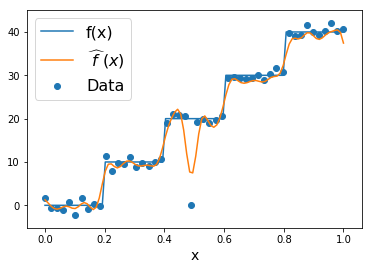

In [13]:
print('gamma\t lambda\t error')
print(best_ls, best_error_ls)
f_hat = cvx_kernel_1d(x_data, y_data, 
                      loss_fn=ls_loss_fn, loss_params=None,
                      kernel=k_rbf, k_params=best_ls[0], lambd=best_ls[1])

plt.plot(x, function(x))
plt.scatter(x_data, y_data)
plt.plot(x, f_hat(x))
plt.legend(['f(x)', '$\widehat{\ f\ }(x)}$', 'Data'], fontsize=16)
plt.xlabel('x', fontsize=14)
plt.savefig('figs/hw4_2a_ls_plt.pdf')
np.savetxt(X=best_ls,fname='figs/hw4_2a_ls.txt')

## Part (b)

In [165]:
g_max = 1000
g_min = 1

lambd_max = 5
lambd_min = .005

M_max = 10
M_min = .1

best_huber = []
best_error_huber = np.inf

for i in range(100):
    gamma0 = np.random.rand()*(g_max-g_min) + g_min
    lambd0 = np.random.rand()*(lambd_max-lambd_min) + lambd_min
    M0 = np.random.rand()*(M_max-M_min) + M_min
    error = k_fold_cv(5, x_data, y_data, huber_loss_fn, M0, k_rbf, gamma0, lambd0)
    if error < best_error_huber:
        best_error_huber = error
        best_huber = [gamma0, lambd0, M0]

gamma	 lambda	 M	 error
[211.24192913487107, 0.02124011738657628, 0.5425240908214689] 2.446577269991375


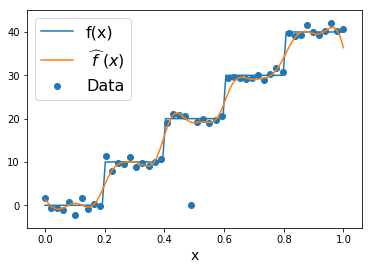

In [195]:
print('gamma\t lambda\t M\t error')
print(best_huber, best_error_huber)
f_hat = cvx_kernel_1d(x_data, y_data, 
                      loss_fn=huber_loss_fn, loss_params=best_huber[2],
                      kernel=k_rbf, k_params=best_huber[0], lambd=best_huber[1])

plt.plot(x, function(x))
plt.scatter(x_data, y_data)
plt.plot(x, f_hat(x))
plt.legend(['f(x)', '$\widehat{\ f\ }(x)}$', 'Data'], fontsize=16)
plt.xlabel('x', fontsize=14)
plt.savefig('figs/hw4_2b_huber_plt.pdf')
np.savetxt(X=best_huber,fname='figs/hw4_2b_huber.txt')

## Part (c)

In [236]:
g_max = 1000
g_min = 1

lambd1_max = 5
lambd1_min = .005

lambd2_max = 5
lambd2_min = .005

best_tv = []
best_error_tv = np.inf

for i in range(100):
    gamma0 = np.random.rand()*(g_max-g_min) + g_min
    lambd1 = np.random.rand()*(lambd1_max-lambd1_min) + lambd1_min
    lambd2 = np.random.rand()*(lambd2_max-lambd2_min) + lambd2_min
    error = k_fold_cv_type2(5, x_data, y_data, ls_loss_fn, None, k_rbf, gamma0, lambd1, lambd2)
    if error < best_error_tv:
        best_error_tv = error
        best_tv = [gamma0, lambd1, lambd2]

gamma	 lambda1	 lambda2	 error
[86.52082151928182, 1.1306168137400177, 0.3220812621248643] 18.153013235327396


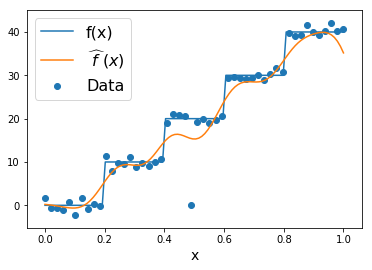

In [237]:
print('gamma\t lambda1\t lambda2\t error')
print(best_tv, best_error_tv)
f_hat = cvx_kernel_1d_type2(x_data, y_data, 
                      loss_fn=ls_loss_fn, loss_params=None,
                      kernel=k_rbf, k_params=best_tv[0],
                      lambd1=best_tv[1], lambd2=best_tv[2])

plt.plot(x, function(x))
plt.scatter(x_data, y_data)
plt.plot(x, f_hat(x))
plt.legend(['f(x)', '$\widehat{\ f\ }(x)}$', 'Data'], fontsize=16)
plt.xlabel('x', fontsize=14)
plt.savefig('figs/hw4_2c_tv_plt.pdf')
np.savetxt(X=best_tv,fname='figs/hw4_2c_tv.txt')

## Part (d)

In [249]:
g_max = 1000
g_min = 1

lambd_max = 5
lambd_min = .005

best_error_qp = np.inf
best_qp = []

for i in range(100):
    gamma0 = np.random.rand()*(g_max-g_min) + g_min
    lambd0 = np.random.rand()*(lambd_max-lambd_min) + lambd_min
    error = k_fold_cv_type3(5, x_data, y_data, ls_loss_fn, None, k_rbf, gamma0, lambd0)
    if error < best_error_qp:
        best_error_qp = error
        best_qp = [gamma0, lambd0]

gamma	 lambda	 	 error
[128.1560331161831, 0.0904303869729249] 15.687072382518682


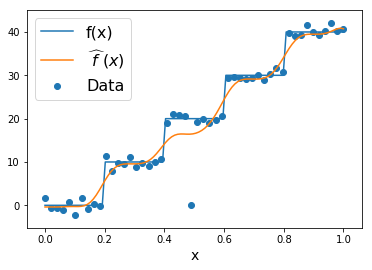

In [251]:
print('gamma\t lambda\t \t error')
print(best_qp, best_error_qp)
f_hat = cvx_kernel_1d_type3(x_data, y_data, loss_fn=ls_loss_fn, loss_params=None,
                            kernel=k_rbf, k_params=best_qp[0], lambd=best_qp[1])

plt.plot(x, function(x))
plt.scatter(x_data, y_data)
plt.plot(x, f_hat(x))
plt.legend(['f(x)', '$\widehat{\ f\ }(x)}$', 'Data'], fontsize=16)
plt.xlabel('x', fontsize=14)
plt.savefig('figs/hw4_2d_qp_plt.pdf')
np.savetxt(X=best_tv,fname='figs/hw4_2d_qp.txt')